# Clustering techniques with GPU accelaration


In [4]:
import math
import numpy as np
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import confusion_matrix
seed = 1988

# Setup data

In [34]:
nb_clusters = 3
nb_samples = 1000000

In [35]:
true_centers = np.random.uniform (-100,100, (nb_clusters,2))
true_centers

array([[ 46.36234398,  66.51608642],
       [ 28.83082239, -98.48807072],
       [ 16.43652197,  40.40603025]])

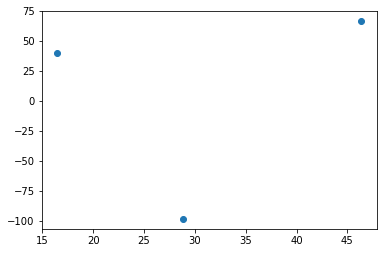

In [36]:
plt.plot(true_centers[:,0],true_centers[:,1], 'o')

In [15]:
cov = np.diag([8.0,8.0])
samples =  np.concatenate([np.random.multivariate_normal(true_centers[i], cov, nb_samples) 
                              for i in range(nb_clusters)])
samples.shape

(30000, 2)

In [16]:
true_labels = np.concatenate([np.ones(nb_samples)*i for i in range(nb_clusters)]).reshape((1,nb_samples*nb_clusters))

In [37]:
def plot_clusters(centers, samples, labels, size = 3):
    plt.figure(figsize=(12,8))
    plt.scatter(samples[:,0],samples[:,1], c=labels, s= size)
    nb_samples_per_center = int(len(samples)/len(centers))
    for i, center in enumerate(centers):
        samples_in_one_center = samples[i*nb_samples_per_center:(i+1)*nb_samples_per_center]
        plt.plot(center[0],center[1], markersize =1, marker ='x', color ='k', mew =25)
        plt.plot(center[0],center[1], markersize =1, marker ='o', color ='k', mew =25)
        

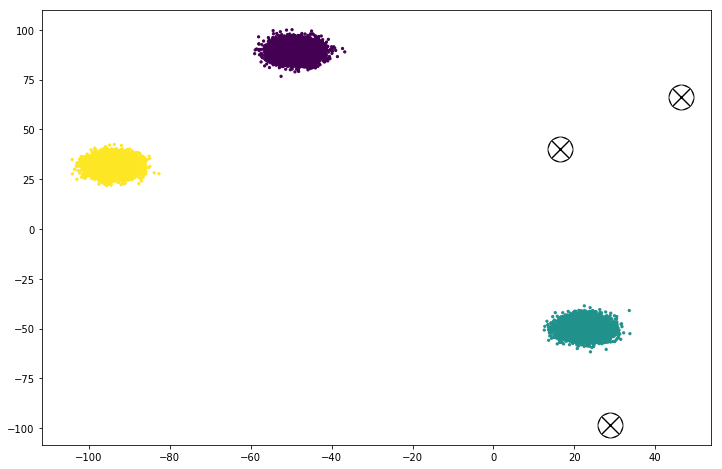

In [39]:
#labels = true_labels.astype(np.float)
plot_clusters(true_centers, samples, true_labels, 3)

# k-mean
## CPU implementation


In [19]:
def random_initialize_centroids(data, nb_centroids):
    samples = np.copy(data)
    np.random.shuffle(samples)
    return samples[:nb_centroids]

In [20]:
def initialize_centroids(data, nb_centroids):
    random_centroid = random_initialize_centroids(data,1)
    centroids = []
    for i in range(nb_centroids):
        distances = np.sqrt(((data - np.expand_dims(random_centroid,1))**2).sum(axis=2)).sum(axis =0)
        max_dist_index = np.argmax(distances, axis =0)
        max_dist_sample = data[max_dist_index]
        centroids.append(max_dist_sample)
        random_centroid = np.stack(max_dist_sample).squeeze()
    return random_centroid    

In [21]:
def nearest_centroid(data, centroids):
    distances = np.sqrt(((data - np.expand_dims(centroids,1))**2).sum(axis=2))
    labels = np.argmin(distances, axis = 0)
    return labels

In [22]:
def move_to_new_centroids(data, labels, centroids):
    unique_labels = range(centroids.shape[0])
    new_centroids = np.array([data[labels ==label].mean(axis=0) for label in unique_labels])
    return  new_centroids   

In [23]:
def k_means(data, nb_centroids, iteration = 1000):
    #centroids = initialize_centroids(data, nb_centroids)
    centroids = random_initialize_centroids(data, nb_centroids)
    for i in range(iteration):
        labels = nearest_centroid(data, centroids)
        new_centroids = move_to_new_centroids(data, labels, centroids)
        centroids = new_centroids
    return centroids, labels    

In [33]:
% time est_centroids, est_labels = k_means(samples, 3,1000) # estimated centroids and labels

CPU times: user 4.45 s, sys: 48 ms, total: 4.5 s
Wall time: 5.7 s


In [ ]:
plot_clusters(est_centroids, samples, est_labels)

## GPU implementation

In [26]:
def tf_random_initialization(data, nb_centroids):
    samples = tf.stack(data)  # convert ndarray in Numpy to tensor in Tensorlow
    nb_samples = tf.shape(data)[0]
    random_indices = tf.random_shuffle(tf.range(0,nb_samples))[:nb_centroids]
    random_centroids = tf.gather(samples, random_indices)
    return random_centroids

In [27]:
def tf_nearest_centroids_labels(data, centroids):
    squared_differences = tf.squared_difference(tf.expand_dims(data,0),tf.expand_dims(centroids,1))
    distances = tf.reduce_sum(squared_differences, axis = 2)
    labels = tf.argmin(distances, axis = 0)
    return labels

In [28]:
def tf_move_to_new_centroids(data, labels, nb_centroids):
    samples = tf.stack(data)
    nearest_labels = tf.to_int32(labels)
    clusters = tf.dynamic_partition(samples, nearest_labels, nb_centroids)    
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(cluster, 0),0) for cluster in clusters],0)
    return new_centroids

In [30]:
def tf_k_means(data, nb_centroids, iteration = 1000):
    tf.global_variables_initializer().run()
    initial_centroids =  tf_random_initialization(data, nb_centroids).eval()
    current_centroids
    
    tf.global_variables_initializer().run()
    for i in range(iteration):
        nearest_centroids_labels = tf_nearest_centroids_labels(data, initial_centroids)
        initial_centroids = tf_move_to_new_centroids(data, nearest_centroids_labels , nb_centroids).eval()

    return initial_centroids, nearest_centroids_labels

In [32]:
%time with tf.Session().as_default(): est_cent, est_labs = tf_k_means(samples, nb_centroids = 3,iteration =1000)

CPU times: user 10min 17s, sys: 3.84 s, total: 10min 21s
Wall time: 12min 10s


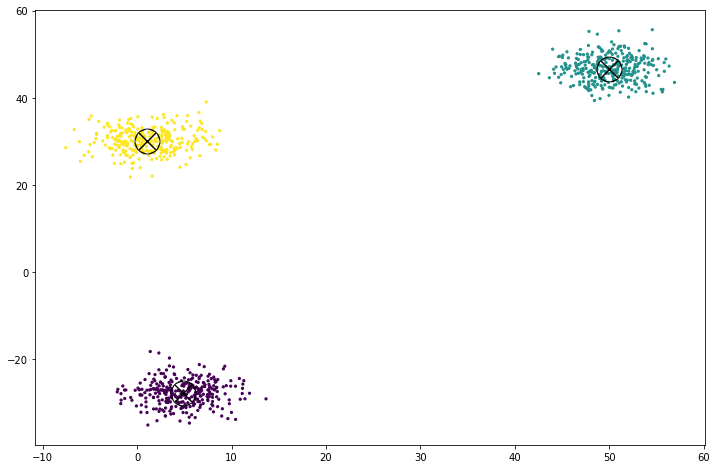

In [36]:
plot_clusters(est_cent, samples, est_labs)

In [336]:
tf.global_variables_initializer().run()

In [360]:
initial_centroids =  tf_random_initialization(samples, nb_centroids =3)
initial_centroids

<tf.Tensor 'Gather_4:0' shape=(?, 2) dtype=float64>

In [338]:
#current_centroids = tf.Variable(initial_centroids)

In [364]:
nearest_centroids_labels = tf_nearest_centroids_labels(samples,initial_centroids)

In [376]:
clusters = tf.dynamic_partition(samples, tf.to_int32(nearest_centroids_labels), 3)   

In [372]:
new_centroids = tf_move_to_new_centroids(samples,nearest_centroids_labels, 3)

In [384]:
new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(cluster, 0),0) for cluster in clusters],0)

In [341]:
Sess = tf.InteractiveSession()

In [361]:
sess = tf.Session()

In [385]:
a = sess.run(new_centroids); a, #en(a)

(array([[-11.14627628, -13.3117413 ],
        [-21.53677794,  37.50075267],
        [-34.44825602, -34.62620901]]),)

In [ ]:
def k_means(data, nb_centroids, iteration = 1000):
    centroids = random_initialize_centroids(data, nb_centroids)
    for i in range(iteration):
        labels = nearest_centroid(data, centroids)
        new_centroids = move_to_new_centroids(data, labels, centroids)
        centroids = new_centroids
    return centroids, labels  

In [309]:
tf.reset_default_graph()

In [310]:
Sess = tf.InteractiveSession()

In [311]:
a = tf.constant(2, name = 'a')

In [312]:
tf_seed =tf.range(1,3); tf_seeding

<tf.Tensor 'range:0' shape=(2,) dtype=int32>

In [313]:
tf_data = tf.concat([[tf_seed*(-1)],[tf_seed], [tf_seed*2], [tf_seed*3], [tf_seed*4]], axis =0)

In [314]:
sess = tf.Session()

In [315]:
b = sess.run(tf_data); b

array([[-1, -2],
       [ 1,  2],
       [ 2,  4],
       [ 3,  6],
       [ 4,  8]], dtype=int32)

In [241]:
b

array([1, 2], dtype=int32)

# Broadcasting in Python

In [571]:
seeding =np.array([1,2]); seeding,seeding.shape

(array([1, 2]), (2,))

In [537]:
data_samples = np.array([seeding*-1,seeding*0,seeding, seeding*2,seeding*3,seeding*4]); data_samples,data_samples.shape

(array([[-1, -2],
        [ 0,  0],
        [ 1,  2],
        [ 2,  4],
        [ 3,  6],
        [ 4,  8]]), (6, 2))

In [538]:
mini_centroids =np.array([[1,2],[1,1]]); mini_centroids, mini_centroids.shape

(array([[1, 2],
        [1, 1]]), (2, 2))

In [539]:
r= np.expand_dims(v2,1); r, r.shape

(array([[[1, 2]],
 
        [[1, 1]]]), (2, 1, 2))

In [540]:
a = data_samples-r;a

array([[[-2, -4],
        [-1, -2],
        [ 0,  0],
        [ 1,  2],
        [ 2,  4],
        [ 3,  6]],

       [[-2, -3],
        [-1, -1],
        [ 0,  1],
        [ 1,  3],
        [ 2,  5],
        [ 3,  7]]])

In [541]:
b= data_samples-mini_centroids[:,np.newaxis];b

array([[[-2, -4],
        [-1, -2],
        [ 0,  0],
        [ 1,  2],
        [ 2,  4],
        [ 3,  6]],

       [[-2, -3],
        [-1, -1],
        [ 0,  1],
        [ 1,  3],
        [ 2,  5],
        [ 3,  7]]])

In [542]:
distances = np.sqrt((b**2).sum(axis =2).astype(np.float)); distances, distances.shape

(array([[ 4.47213595,  2.23606798,  0.        ,  2.23606798,  4.47213595,
          6.70820393],
        [ 3.60555128,  1.41421356,  1.        ,  3.16227766,  5.38516481,
          7.61577311]]), (2, 6))

In [543]:
distances_1 = np.sqrt((a**2).sum(axis =2).astype(np.float)); distances_1, distances_1.shape

(array([[ 4.47213595,  2.23606798,  0.        ,  2.23606798,  4.47213595,
          6.70820393],
        [ 3.60555128,  1.41421356,  1.        ,  3.16227766,  5.38516481,
          7.61577311]]), (2, 6))

In [608]:
mini_labels = np.argmin(distances_1, axis =0); mini_labels

array([1, 1, 0, 0, 0, 0])

In [545]:
labels = range(mini_centroids.shape[0]); labels

range(0, 2)

In [553]:
data_samples[mini_labels==0], data_samples[mini_labels==1]

(array([[1, 2],
        [2, 4],
        [3, 6],
        [4, 8]]), array([[-1, -2],
        [ 0,  0]]))

In [547]:
data_samples[mini_labels==0].mean(axis=0)

array([ 2.5,  5. ])

In [550]:
new_centroids(data_samples, mini_labels, mini_centroids )

array([[ 2.5,  5. ],
       [-0.5, -1. ]])

In [ ]:
new_mini_centroids = np.copy(mini_centroids)
for i in labels:
    new_mini_centroids[i,:] = 

In [605]:
distances[1]

array([ 3.60555128,  1.41421356,  1.        ,  3.16227766,  5.38516481,
        7.61577311])

In [607]:
np.argmin(distances[1], axis =0)

2

## kmeans skilearn

In [408]:
kmeans = KMeans(n_clusters = nb_clusters).fit(samples)

In [234]:
km_est_centers = kmeans.cluster_centers_

In [235]:
est_labels = kmeans.labels_

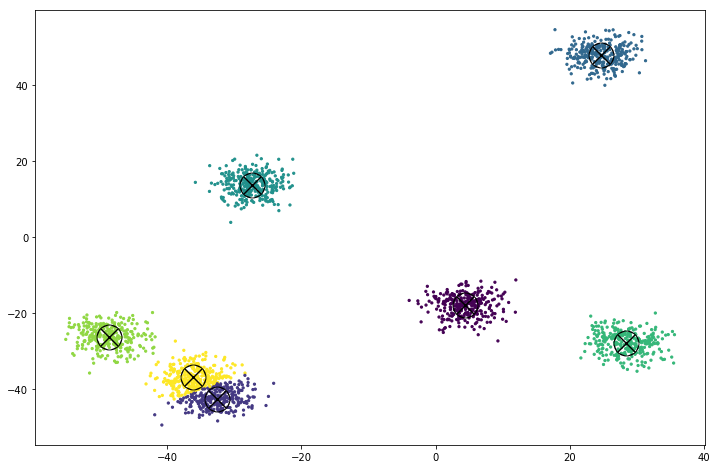

In [236]:
plot_clusters(km_est_centers, samples, est_labels)

# Mean shift

## CPU implementation

In [274]:
# Gaussian kernel
def gau_kernel(mean, sdt):
    kernel = 1/math.sqrt(2*math.pi*sdt**2)*np.exp(-1/2*(mean-sdt)**2/sdt**2) 
    return kernel

In [336]:
def meanshift(samples, bandwidth, iteration):
    data = np.copy(samples)
    for it in range(iteration):
        for i, data_point in enumerate(data):
            distance = np.sqrt(((data_point - data)**2).sum(axis =1))# Get distances from one points to all points
            weight = gau_kernel(distance, bandwidth) # Get corresponding weights for all distances
            shift =  np.expand_dims(weight,1)*data # Shift all remaining points according to weights
            mean =  shift.sum(axis =0)/weight.sum() # Get the mean for all shifted points 
            data[i] = mean # Assign the current point to the mean
    return data    

In [361]:
%time X = meanshift(samples, 3, 10)

CPU times: user 4.23 s, sys: 4 ms, total: 4.24 s
Wall time: 4.95 s


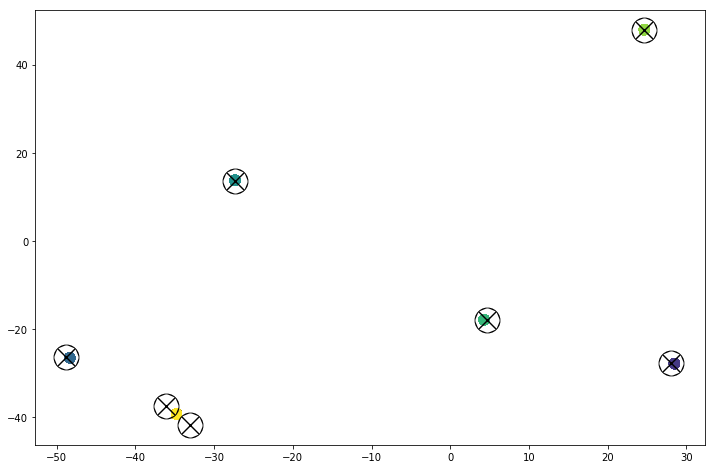

In [362]:
plot_clusters(true_centers, X, true_labels, 100)